# MLP - To Be prepared

This was followed up with a modified dataset using TSNS feature selection

5 features were selected and used for training, of these 5 there was a problem with MACDFIX which did not behave as expected, so a 6th was realized

Using normalization did not yield satisfying results (converged at ~57) so the report is skipped, and normalization is not performed for this. However, further trials are to come

The selected features are: ADX, AROONOSC, BOP, PLUS_DM, PPO	

## Best model as returned from Hyperparameter tuning

For this the data was preped using ModDataset and then undersampled, this data was then fed to the Hyperband tuner and after 24 hours it was interrupted and the best model was used for this analysis

The next step in preprocessing will be to configure the other architectures and then use these as secondary input for the MLP, for this several models will have to be trained. It will also be tested if the improvement seen from feeding other tempeoral Data into this network increases performance, it may be usefull to implement a Bi-Direction ConvLSTM layer at the beginning of the network to properly account for the temporal Data.

In [5]:
%matplotlib inline
import sys
sys.path.append('../..')
import numpy as np
from keras_tuner import Hyperband
from OptimizeNN_keras import MultiLayerPerceptron
from eval_network import Eval_Model
from Raw_Data import ModDataset
import datetime as dt
import matplotlib.pyplot as plt

## Retrieve the model

In [10]:
tuner = Hyperband(
    hypermodel = MultiLayerPerceptron,
    max_epochs=1000, #TODO: set this to a value slightly higher than the expected epochs to convergence for your largest Mode
    objective="accuracy", 
    factor=5,
    hyperband_iterations=2, #In my interest to set as high as possible, max_epochs * (math.log(max_epochs, factor) ** 2)  one iteration runs prior nr of epochs across trials
    directory='/home/felix/NeuralNetworks/MLP_SP_under',
    project_name= 'MLP_SP_under'
)
tuner.reload()

INFO:tensorflow:Reloading Oracle from existing project /home/felix/NeuralNetworks/MLP_SP_under/MLP_SP_under/oracle.json
INFO:tensorflow:Reloading Tuner from /home/felix/NeuralNetworks/MLP_SP_under/MLP_SP_under/tuner0.json


In [11]:
params = tuner.get_best_hyperparameters(num_trials=1)[0].get_config()['values']
for key in params.keys():
    print(key, ' : ', params[key])
model = tuner.get_best_models()[0]

Dense1  :  12
Dense2  :  17
Dense3  :  12
learning rate  :  0.01
epsilon  :  0.001
tuner/epochs  :  1000
tuner/initial_epoch  :  200
tuner/bracket  :  4
tuner/round  :  4
tuner/trial_id  :  b8e241a37b4364f8c37918d5e8992ba3


## First lets visualize how the Model places its buys holds and sells

In [14]:
import plotly.express as px
import pandas as pd
import numpy as np
import plotly.graph_objects as go

test_data = ModDataset('/home/felix/MLP_stockdata/yf_AAPL.pkl')
#Prepare for plotting
test_data.data['Date']=test_data.data['Date'].map(lambda x: dt.datetime.strptime(x,'%Y-%m-%dT00:00:00.000000000'))
#Make predictions
pred = model.predict(test_data.data.iloc[::,6:-3].to_numpy())


r=[]
g=[]
b=[]
for i in range(len(pred)):
    decision= get_index(pred[i]) #1Buy 2Hold 3Sell
    if decision==1: r.append([test_data.data['Date'].iloc[i],test_data.data['open'].iloc[i],'#7CFC00'])
    if decision==2: g.append([test_data.data['Date'].iloc[i],test_data.data['open'].iloc[i],'#1E90FF'])
    if decision==3: b.append([test_data.data['Date'].iloc[i],test_data.data['open'].iloc[i],'#DC143C'])
r = np.array(r,dtype=object).transpose()
g = np.array(g,dtype=object).transpose()
b = np.array(b,dtype=object).transpose()



fig = go.Figure()

fig.add_trace(go.Scatter(x=r[0],y=r[1],mode = 'markers',name='buy'))
fig.add_trace(go.Scatter(x=g[0],y=g[1],mode = 'markers',name='hold'))
fig.add_trace(go.Scatter(x=b[0],y=b[1],mode = 'markers',name='sell'))
fig.add_trace(go.Scatter(x=test_data.data['Date'],y=test_data.data['open'],mode = 'lines',name='close'))

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)


fig.show()

## Now lets plot the annualized performance on the different stocks

In [15]:

evaluator = Eval_Model(model, '/home/felix/MLP_stockdata/')
evaluator.compute()

mean  ±  std: 1146.891619718331 ± 3751.1493500419033
median 122.05500342533117
Ignoring the top 50 results
mean  ±  std: 292.98512630648906 ± 459.1908495215032
median 96.87056081231898


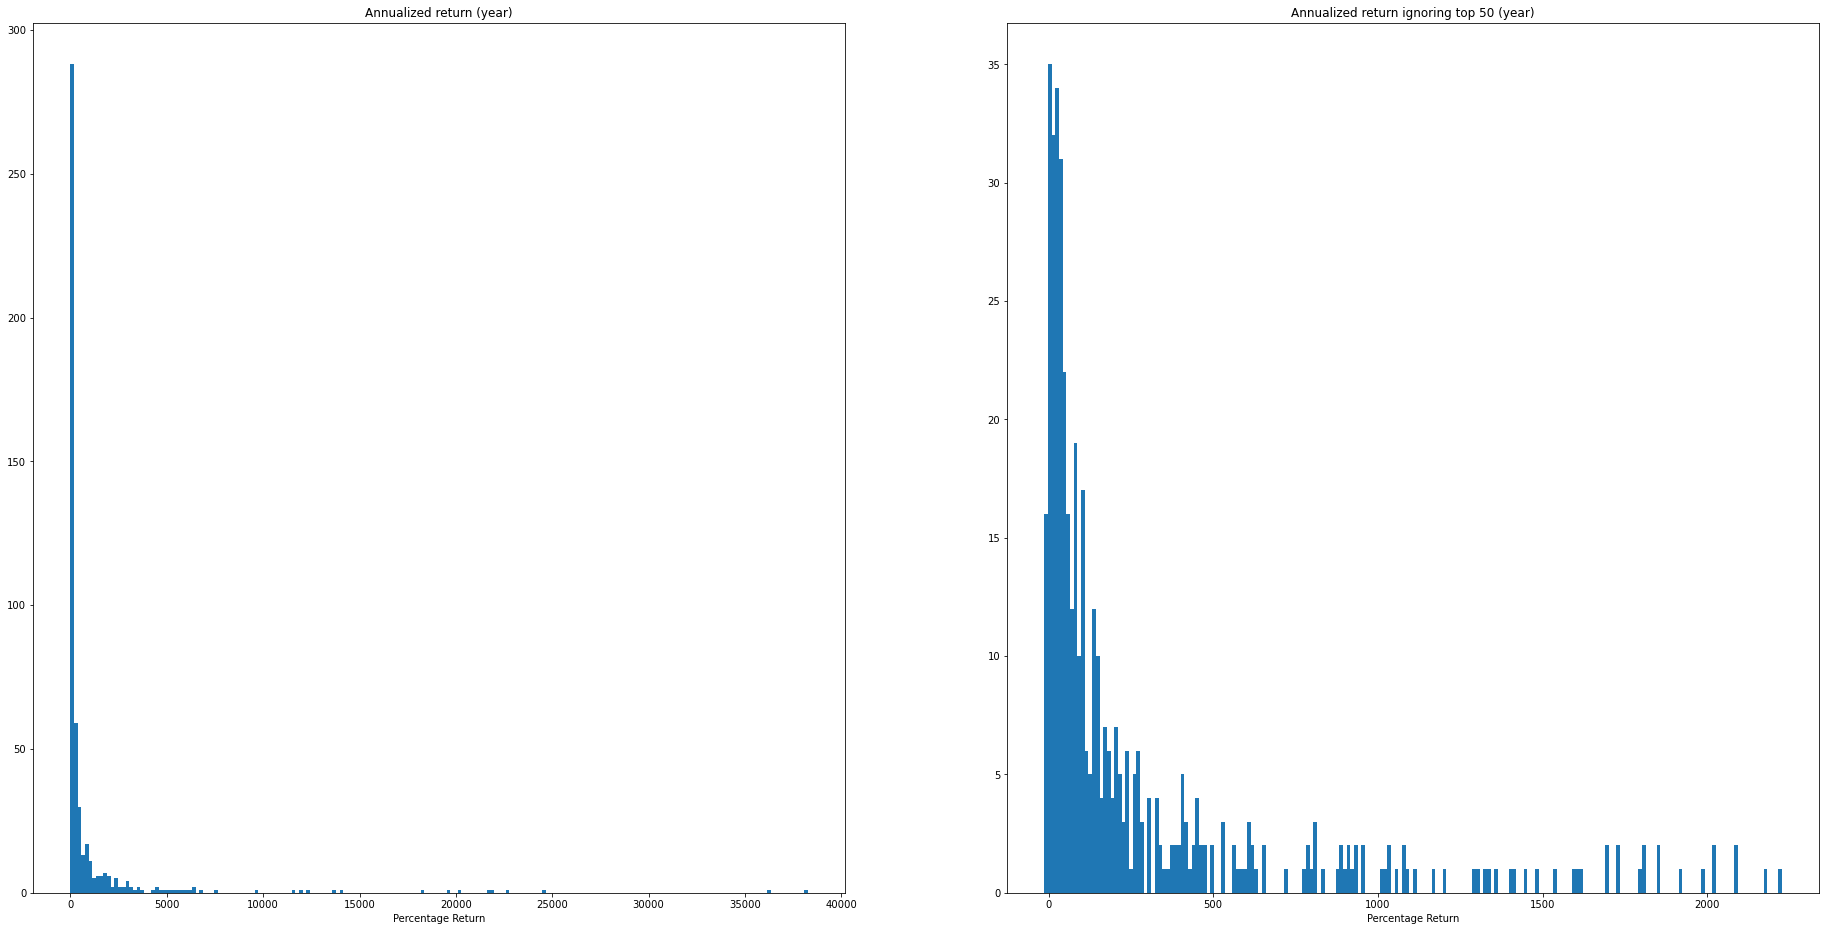

In [16]:
evaluator.make_plot(year=True)

mean  ±  std: 3.142168821146112 ± 10.27712150696412
median 0.3343972696584415
Ignoring the top 50 results
mean  ±  std: 0.8026989761821618 ± 1.258057121976721
median 0.26539879674607936


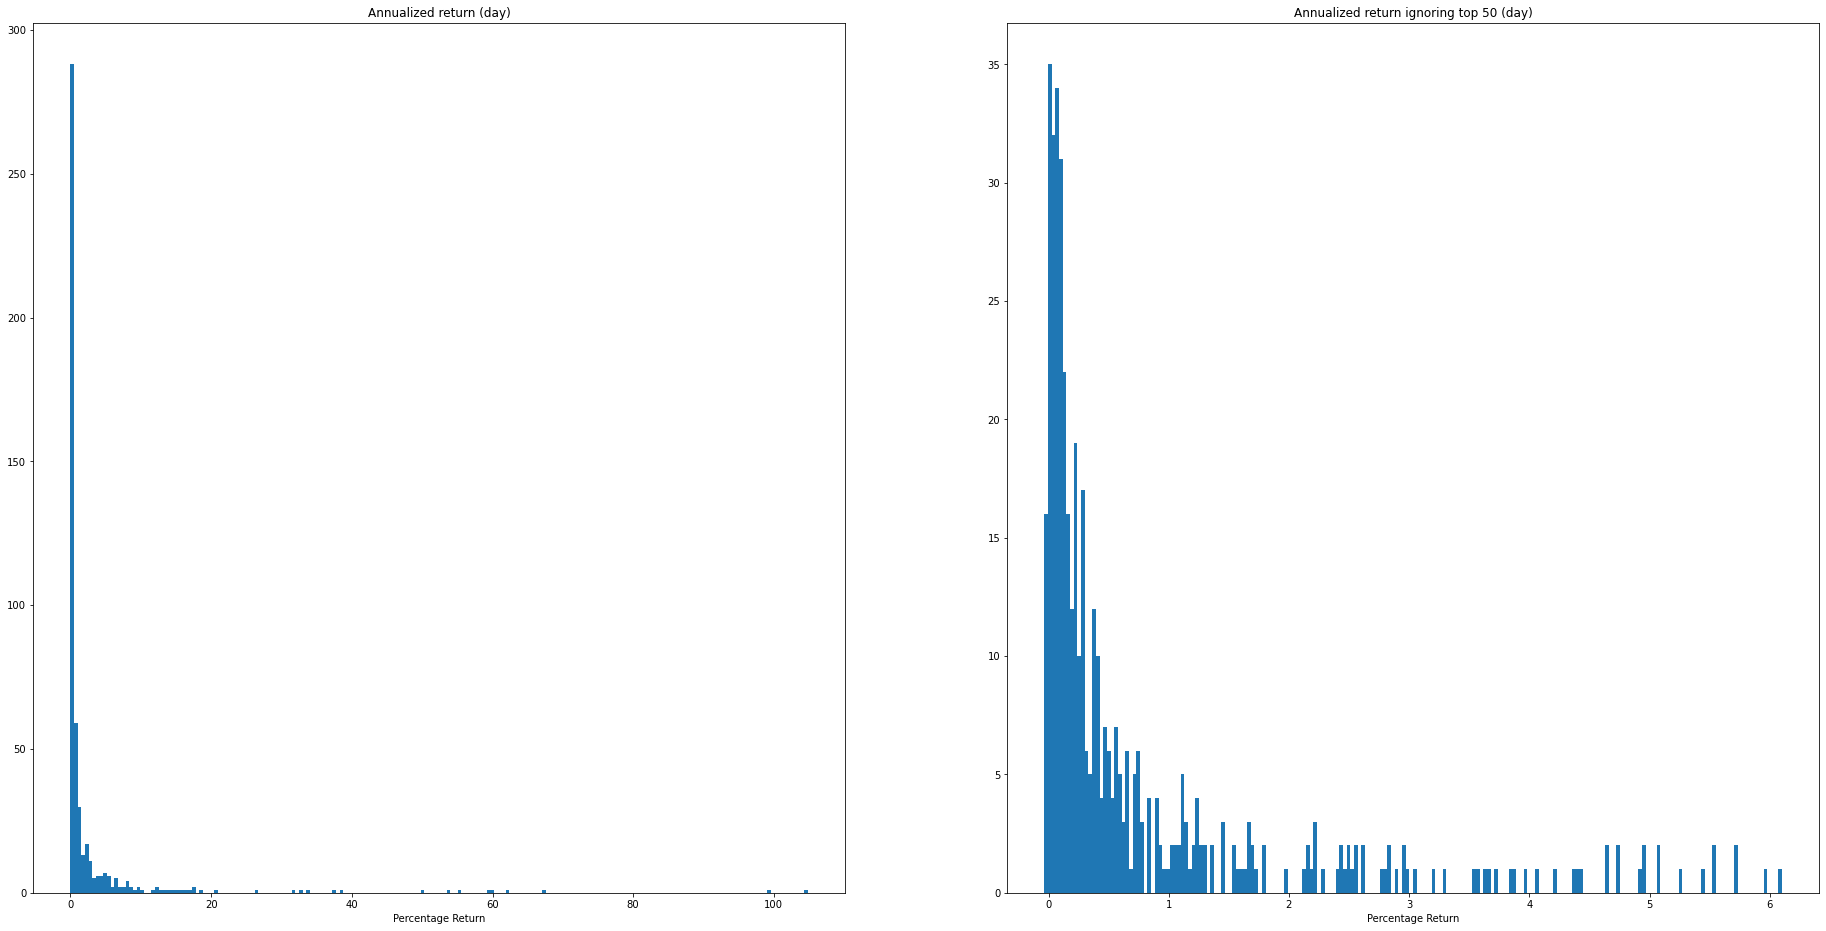

In [17]:
evaluator.make_plot(day=True)

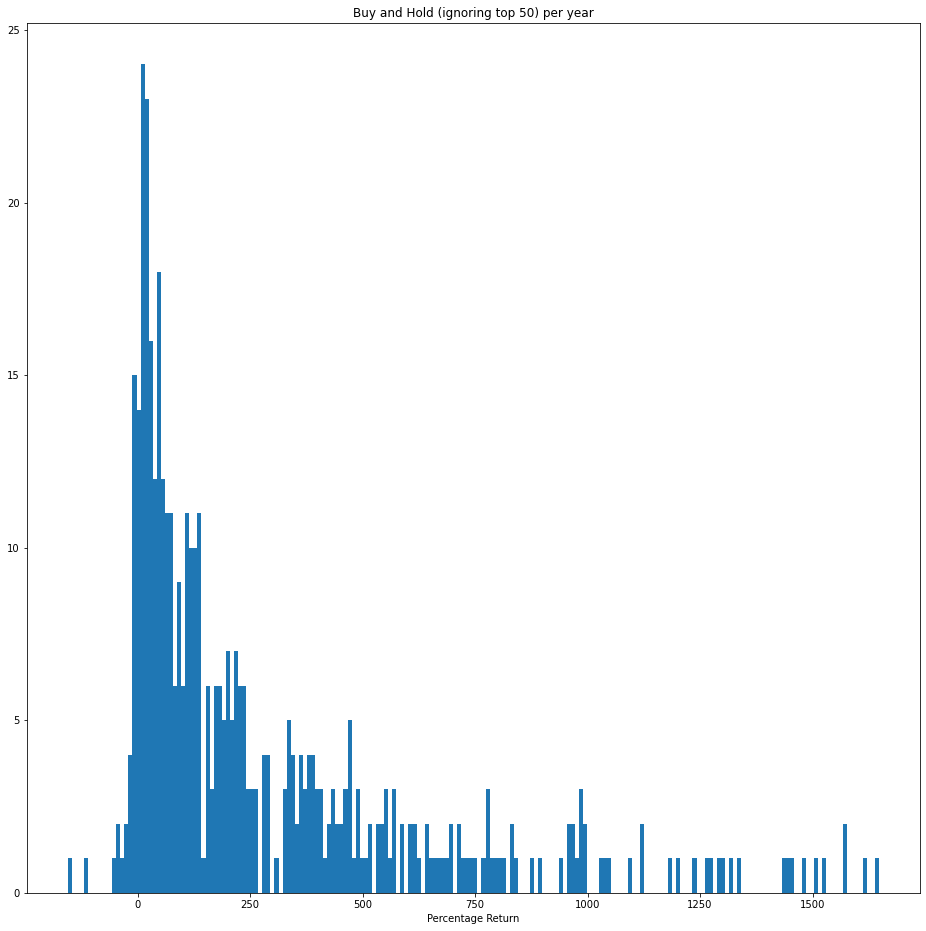

In [18]:
evaluator.buy_and_hold_plot()

Above we find 6 graphs, the first two represent the annualized profits per year for all stocks in the SP500 and the annualized profits per year excluding the top 50 performers.
The third and forth represent the same data but annualized per day.
And the last two represent purchasing the stock on the day they came out and then selling them on the most recent data point

One thing to keep in mind when viewing the last plots, is that these are the best performing stocks in the US, so Buy and Hold will on average yield lower results (If im not mistaken, I very well could be)

Also note that the network has less performers in the negative range.

The same applies here as in the non normal notebook as no further inclusion was made, we only changed the identifiers used, this did improve perfomance by 2.6 % on daily profits including all SP500 stocks and 0.5% improvement over the 450 worst performers of this dataset

## Now to focus on the neural network itself rather than its performance on stocks

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

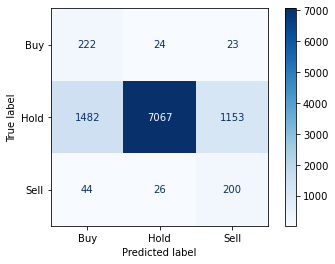

In [20]:
#Using the prediction made earlier
y_pred = np.array([get_index(i) for i in pred])
#Get data
y_act = test_data.data.iloc[::,-3::].to_numpy()
#Create identifiers
y_act = np.array([np.sum(i*[1,2,3]) for i in y_act])

labels = ["Buy", "Hold", "Sell"]

cm = confusion_matrix(y_act, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

The confusion matrix however appears to be very similar

It will be usefull to construct a loss function based on total profits rather than scipy's peak identification, however I am not sure this will actually yield results